In [1]:
from coffea.nanoevents import BaseSchema, NanoEventsFactory
import dask_awkward as dak
import awkward as ak
import matplotlib.pyplot as plt
import numpy as np
import hist
import mplhep as hep
import numba
from coffea.analysis_tools import PackedSelection
import vector
vector.register_awkward()

In [2]:
events = NanoEventsFactory.from_root(
    file="../data/p8_ee_ZH_ecm240/events_101027117.root:events",
    schemaclass=BaseSchema,
    # schemaclass=DelphesSchema, Doesn't work 
    # schemaclass=NanoAODSchema.v7, Doesn't work
    metadata={
        "path":"/eos/experiment/fcc/ee/generation/DelphesEvents/spring2021/IDEA/p8_ee_ZH_ecm240/events_101027117.root",
        "name":"p8_ee_ZH_ecm240",
        "process":"ZH to mumu, ecm=240 GeV"
    }
).events()

In [3]:
from coffea.analysis_tools import PackedSelection

In [4]:
def index_mask(input_array, index_array):
    '''
    This function matches the given attribute of ReconstructedParticles (for example energy) to the particle index (for example Muon or Electron)
    '''
    # input_array = input_array.compute()
    # index_array = index_array.compute()
    if len(input_array) != len(index_array) :
        raise Exception(f'Length of input_array({len(input_array)}) and index_array({len(index_array)}) does not match!')
    counts = len(index_array)
    
    @numba.jit
    def numba_wrap(input_array, index_array, counts):
        output_array = []
        for event_index in range(counts):
            event_mask = index_array[event_index]
            reco_list = input_array[event_index]
            output_array.append([reco_list[i] for i in  event_mask])
        return output_array
    out = ak.Array(numba_wrap(input_array,index_array,counts))
    
    return out

In [5]:
cut = PackedSelection()
Recon = events['ReconstructedParticles/ReconstructedParticles.energy']
cut.add('No cut', ak.all(Recon.compute() > 0, axis=1))

# Filter out any event with no reconstructed particles and generate Reconstructed Particle Attributes
#ak.mask preserves array length
Reco_E = ak.mask(events['ReconstructedParticles/ReconstructedParticles.energy'],ak.num(Recon) > 0).compute()
Reco_px = ak.mask(events['ReconstructedParticles/ReconstructedParticles.momentum.x'],ak.num(Recon) > 0).compute()
Reco_py = ak.mask(events['ReconstructedParticles/ReconstructedParticles.momentum.y'],ak.num(Recon) > 0).compute()
Reco_pz = ak.mask(events['ReconstructedParticles/ReconstructedParticles.momentum.z'],ak.num(Recon) > 0).compute()
Reco_q = ak.mask(events['ReconstructedParticles/ReconstructedParticles.charge'],ak.num(Recon) > 0).compute()
Reco_mass = ak.mask(events['ReconstructedParticles/ReconstructedParticles.mass'],ak.num(Recon) > 0).compute()
cut.add('At least one Reco Particle', ak.all(Reco_E > 0, axis=1))

# Generate Muon Attributes
Muon_index = events['Muon#0/Muon#0.index'].compute()
Muon_E = index_mask(Reco_E,Muon_index)
Muon_px = index_mask(Reco_px,Muon_index)
Muon_py = index_mask(Reco_py,Muon_index)
Muon_pz = index_mask(Reco_pz,Muon_index)
Muon_q = index_mask(Reco_q,Muon_index)
Muon_mass = index_mask(Reco_mass,Muon_index)

# Create Array of Muon Lorentz Vector 
Muon = ak.zip({"px":Muon_px,"py":Muon_py,"pz":Muon_pz,"E":Muon_E,"q":Muon_q,}, with_name="Momentum4D")

# Muon pt > 10
Muon_pt_cut = ak.all(Muon.pt > 10, axis=1)
Muon = ak.mask(Muon, Muon_pt_cut) #ak.mask to preserve number of events
cut.add('Muon $p_T$ > 10 [GeV]',Muon_pt_cut)

# Produce all the combinations of Muon Pairs possible within an event
combs = ak.combinations(Muon,2)

# Get dimuons
mu1 , mu2 = ak.unzip(combs)
di_muon = mu1 + mu2

# Selection 0 : Only one Z candidate in an event
di_muon = ak.mask(di_muon, ak.num(di_muon) == 1)
di_muon_mass = ak.flatten(di_muon.mass)
cut.add('$N_Z$',ak.num(Muon) == 2 ) #Having one Z candidate is same as having exactly two muons in an even

# Choose dimuon which is made up of two oppositely charged muons
q_sum = mu1.q + mu2.q
q_sum_array = ak.mask(q_sum, ak.num(q_sum) == 1)
q_sum_mask = ak.all(q_sum_array == 0, axis=1)
Z_cand = ak.mask(di_muon , q_sum_mask)
cut.add('Opp charge muons',q_sum_mask)

#Recoil Calculation
ecm = 240 #GeV # com energy
initial = ak.zip({"px":0,"py":0,"pz":0,"E":ecm}, with_name="Momentum4D")
Recoil = initial - Z_cand

# Selection 1 : Selection 0 + 80 < M_Z < 100
zmassmask = (Z_cand.mass > 80) & (Z_cand.mass < 100)
Z_cand_sel1 = Z_cand[zmassmask]
Recoil_sel1 = Recoil[zmassmask]
zmassmask = ak.fill_none(zmassmask,[False],axis=0) #Replace None values at axis 0 with [False]
zmassmask = ak.flatten(zmassmask)
cut.add('80 < $M_Z$ < 100',zmassmask)

#Prepare cutflows
sel0_list = ['No cut','At least one Reco Particle', 'Muon $p_T$ > 10 [GeV]', '$N_Z$', 'Opp charge muons' ]
sel1_list = ['No cut','At least one Reco Particle', 'Muon $p_T$ > 10 [GeV]', '$N_Z$', 'Opp charge muons', '80 < $M_Z$ < 100']
sel0 = cut.cutflow(*sel0_list)
sel1 = cut.cutflow(*sel1_list)

#Prepare output
Output = {
    'histograms': {
        'sel0': {
        'Zm': hist.Hist.new.Regular(125,0,250).Double().fill(ak.flatten(Z_cand.mass)),
        'Zm_zoom' : hist.Hist.new.Regular(40,80,100).Double().fill(ak.flatten(Z_cand.mass)),
        'Recoilm': hist.Hist.new.Regular(100,0,200).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom' : hist.Hist.new.Regular(200,80,160).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom1' : hist.Hist.new.Regular(100,120,140).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom2' : hist.Hist.new.Regular(200,120,140).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom3' : hist.Hist.new.Regular(400,120,140).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom4' : hist.Hist.new.Regular(800,120,140).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom5' : hist.Hist.new.Regular(2000,120,140).Double().fill(ak.flatten(Recoil.mass)),
        'Recoilm_zoom6' : hist.Hist.new.Regular(100,130.3,132.5).Double().fill(ak.flatten(Recoil.mass))
        },
        'sel1': {
        'Zm': hist.Hist.new.Regular(125,0,250).Double().fill(ak.flatten(Z_cand_sel1.mass)),
        'Zm_zoom' : hist.Hist.new.Regular(40,80,100).Double().fill(ak.flatten(Z_cand_sel1.mass)),
        'Recoilm': hist.Hist.new.Regular(100,0,200).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom' : hist.Hist.new.Regular(200,80,160).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom1' : hist.Hist.new.Regular(100,120,140).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom2' : hist.Hist.new.Regular(200,120,140).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom3' : hist.Hist.new.Regular(400,120,140).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom4' : hist.Hist.new.Regular(800,120,140).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom5' : hist.Hist.new.Regular(2000,120,140).Double().fill(ak.flatten(Recoil_sel1.mass)),
        'Recoilm_zoom6' : hist.Hist.new.Regular(100,130.3,132.5).Double().fill(ak.flatten(Recoil_sel1.mass))
        }
    },
    'cutflow': { #cutflow objects
        'sel0': sel0,
        'sel1': sel1
    }
}

In [6]:
Output

{'histograms': {'sel0': {'Zm': Hist(Regular(125, 0, 250, label='Axis 0'), storage=Double()) # Sum: 2760.0,
   'Zm_zoom': Hist(Regular(40, 80, 100, label='Axis 0'), storage=Double()) # Sum: 2236.0 (2760.0 with flow),
   'Recoilm': Hist(Regular(100, 0, 200, label='Axis 0'), storage=Double()) # Sum: 2738.0 (2760.0 with flow),
   'Recoilm_zoom': Hist(Regular(200, 80, 160, label='Axis 0'), storage=Double()) # Sum: 2549.0 (2760.0 with flow),
   'Recoilm_zoom1': Hist(Regular(100, 120, 140, label='Axis 0'), storage=Double()) # Sum: 2246.0 (2760.0 with flow),
   'Recoilm_zoom2': Hist(Regular(200, 120, 140, label='Axis 0'), storage=Double()) # Sum: 2246.0 (2760.0 with flow),
   'Recoilm_zoom3': Hist(Regular(400, 120, 140, label='Axis 0'), storage=Double()) # Sum: 2246.0 (2760.0 with flow),
   'Recoilm_zoom4': Hist(Regular(800, 120, 140, label='Axis 0'), storage=Double()) # Sum: 2246.0 (2760.0 with flow),
   'Recoilm_zoom5': Hist(Regular(2000, 120, 140, label='Axis 0'), storage=Double()) # Sum: 2

In [7]:
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

''

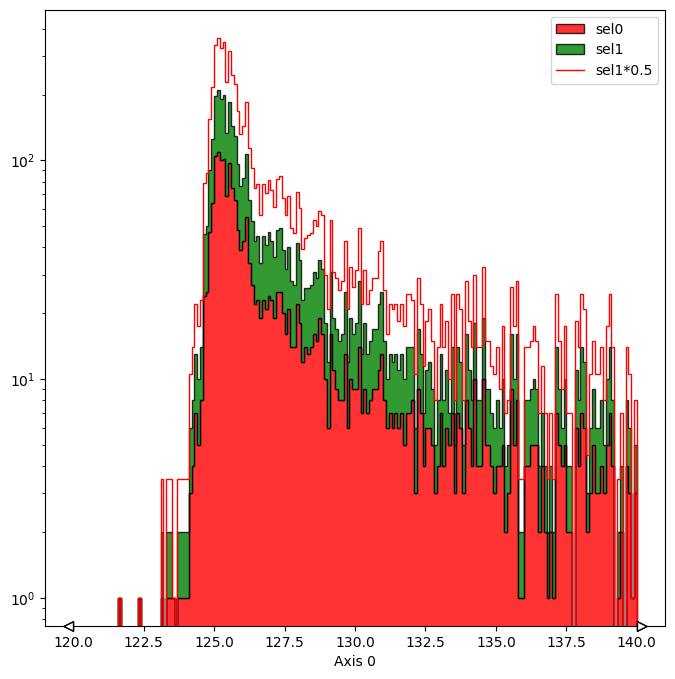

In [57]:
Stack = True
fig,ax = plt.subplots(figsize=(8,8))
bkgs = [Output['histograms']['sel0']['Recoilm_zoom2'], Output['histograms']['sel1']['Recoilm_zoom2']]
sigl = [Output['histograms']['sel1']['Recoilm_zoom2']*1.5]
hep.histplot(
    bkgs,
    color = ['r','g'],
    yerr= 0,
    label=['sel0','sel1'],
    histtype='fill',
    stack=True,
    alpha=0.8,
    edgecolor='black',
    linewidth=1,
    sort='yield_r',
    ax=ax
)
if Stack :
    sigl_hist = sum(sigl)+sum(bkgs) #Manual stacking
else:
    sigl_hist = sigl
hep.histplot(
    sigl_hist,
    color=['r'],
    label=['sel1*0.5'],
    histtype='step',
    stack=False,
    linewidth=1,
    ax=ax
)
ax.legend()
ax.set_yscale('log')
;

In [47]:
sum([Output['histograms']['sel0']['Recoilm_zoom'], Output['histograms']['sel0']['Recoilm_zoom']*2])

Hist(Regular(200, 80, 160, label='Axis 0'), storage=Double()) # Sum: 7647.0 (8280.0 with flow)